## Нейронная сеть

### Предобработка данных

In [18]:
import pandas as pd

# Загрузка данных
sales_train = pd.read_csv('sales_train.csv')

sales_train = sales_train[(sales_train['item_cnt_day'] > 0) & (sales_train['item_price'] > 0) & (sales_train['item_price'] < 100000) & (sales_train['item_cnt_day'] < 500)]


# Преобразование даты
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# Расчет двухнедельных и месячных периодов для каждого года
sales_train['year'] = sales_train['date'].dt.year
sales_train['two_week_period'] = sales_train['date'].dt.isocalendar().week // 2 + 1
sales_train['month'] = sales_train['date'].dt.month
sales_train['date_block_week'] = sales_train['year'].astype(str) + '_' + sales_train['two_week_period'].astype(str)
sales_train['date_block_month'] = sales_train['year'].astype(str) + '_' + sales_train['month'].astype(str)

# Расчет средних значений за двухнедельные и месячные периоды
mean_prices_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_price'].mean().reset_index()
mean_sales_weekly = sales_train.groupby(['item_id', 'date_block_week'])['item_cnt_day'].mean().reset_index()
mean_prices_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_price'].mean().reset_index()
mean_sales_monthly = sales_train.groupby(['item_id', 'date_block_month'])['item_cnt_day'].mean().reset_index()

# Присоединяем средние цены и количество продаж обратно к основным данным
sales_train = sales_train.merge(mean_prices_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_sales_weekly, on=['item_id', 'date_block_week'], suffixes=('', '_mean_week'))
sales_train = sales_train.merge(mean_prices_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))
sales_train = sales_train.merge(mean_sales_monthly, on=['item_id', 'date_block_month'], suffixes=('', '_mean_month'))

# Фильтрация данных
sales_train['price_diff'] = abs(sales_train['item_price'] - sales_train['item_price_mean_week']) / sales_train['item_price_mean_week']
filtered_data = sales_train[sales_train['price_diff'] > 0.05]

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

# Загрузка данных
train_data = filtered_data  # Предполагаем, что данные уже загружены и фильтрованы

# Объединение данных и предварительная обработка
data_items = pd.read_csv('items.csv')
train_data = pd.merge(train_data, data_items, on='item_id')
train_data = train_data.drop(columns=['item_name', 'date_block_week', 'date_block_month', 'price_diff', 'date_block_num', 'two_week_period'])

# Преобразование даты
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['is_weekend'] = train_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
train_data['day_of_year'] = train_data['date'].dt.dayofyear  # добавлено для сезонности

# Кодирование категориальных признаков
label_encoders = {col: LabelEncoder() for col in ['shop_id', 'item_id', 'item_category_id']}
for col, le in label_encoders.items():
    train_data[col] = le.fit_transform(train_data[col])

# Логарифмирование целевой переменной
train_data['item_cnt_day'] = np.log1p(train_data['item_cnt_day'])

# Нормализация числовых признаков
scaler = StandardScaler()
num_features = ['item_price', 'item_cnt_day_mean_week', 'item_cnt_day_mean_month', 'day', 'item_price_mean_week', 'item_price_mean_month', 'year', 'month', 'day_of_year', 'is_weekend']
train_data[num_features] = scaler.fit_transform(train_data[num_features])

# Разделение на обучающий и тестовый наборы
cutoff_index = int(len(train_data) * 0.9)
X_train, X_test = train_data.iloc[:cutoff_index], train_data.iloc[cutoff_index:]
y_train, y_test = X_train['item_cnt_day'], X_test['item_cnt_day']

# Конвертация данных в тензоры
def convert_to_tensor(dataframe):
    if dataframe.isnull().values.any():
        raise ValueError("Dataframe contains missing values.")
    return torch.tensor(dataframe.drop(['item_cnt_day', 'date'], axis=1).values, dtype=torch.float)

X_train_tensor = convert_to_tensor(X_train)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_test_tensor = convert_to_tensor(X_test)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)


### Обучим модель

In [20]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNet(nn.Module):
    def __init__(self, num_features):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 15)
        self.bn1 = nn.BatchNorm1d(15)
        self.ln1 = nn.LayerNorm(15)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(15, 15)
        self.bn2 = nn.BatchNorm1d(15)
        self.ln2 = nn.LayerNorm(15)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(15, 15)
        self.fc4 = nn.Linear(15, 15)
        self.fc5 = nn.Linear(15, 15)
        self.fc6 = nn.Linear(15, 15)
        self.fc7 = nn.Linear(15, 15)
        self.fc8 = nn.Linear(15, 15)
        self.fc9 = nn.Linear(15, 1)
        self.projection = nn.Linear(num_features, 15)  # Проекционный слой для согласования размерности

    def forward(self, x):
        identity = self.projection(x)  # Применение проекционного слоя к исходному входу
        x = F.relu(self.ln1(self.bn1(self.fc1(x))))
        x = self.dropout1(x)
        x = x + identity  # Добавление residual connection
        
        x = F.relu(self.ln2(self.bn2(self.fc2(x))))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        return self.fc9(x)

    
class QuantileSmoothL1Loss(nn.Module):
    def __init__(self, quantile=0.65, beta=1.0):
        super().__init__()
        self.quantile = quantile
        self.beta = beta

    def forward(self, inputs, targets):
        errors = targets - inputs
        condition = errors >= 0  # исправлено на сравнение, возвращающее булев тензор
        losses = torch.where(condition,
                             self.quantile * torch.abs(errors),
                             (1 - self.quantile) * torch.abs(errors))
        
        # Applying Smooth L1 Loss
        condition = torch.abs(losses) < self.beta
        l1_losses = 0.5 * (losses ** 2) / self.beta
        l2_losses = torch.abs(losses) - 0.5 * self.beta
        
        return torch.where(condition, l1_losses, l2_losses).mean()


criterion = QuantileSmoothL1Loss(quantile=0.65, beta=1.0)

model = NeuralNet(X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, criterion, optimizer, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train(model, criterion, optimizer, train_loader, epochs=5)

model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    actual = np.expm1(y_test_tensor.cpu().numpy().flatten())
    predictions = np.expm1(model(X_test_tensor).cpu().detach().numpy().flatten())

scale_factor = 1
predictions_scaled = predictions * scale_factor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_scaled = mean_squared_error(actual, predictions_scaled)
rmse_scaled = np.sqrt(mse_scaled)
mae_scaled = mean_absolute_error(actual, predictions_scaled)
r_squared_scaled = r2_score(actual, predictions_scaled)

print(f"Scaled MSE: {mse_scaled}, RMSE: {rmse_scaled}, MAE: {mae_scaled}, R^2: {r_squared_scaled}")


Epoch [1/5], Loss: 0.0018
Epoch [2/5], Loss: 0.0089
Epoch [3/5], Loss: 0.0021
Epoch [4/5], Loss: 0.0029
Epoch [5/5], Loss: 0.0034
Scaled MSE: 8.120474815368652, RMSE: 2.849644660949707, MAE: 0.5893381237983704, R^2: 0.00103839620171009


### Выведем результаты

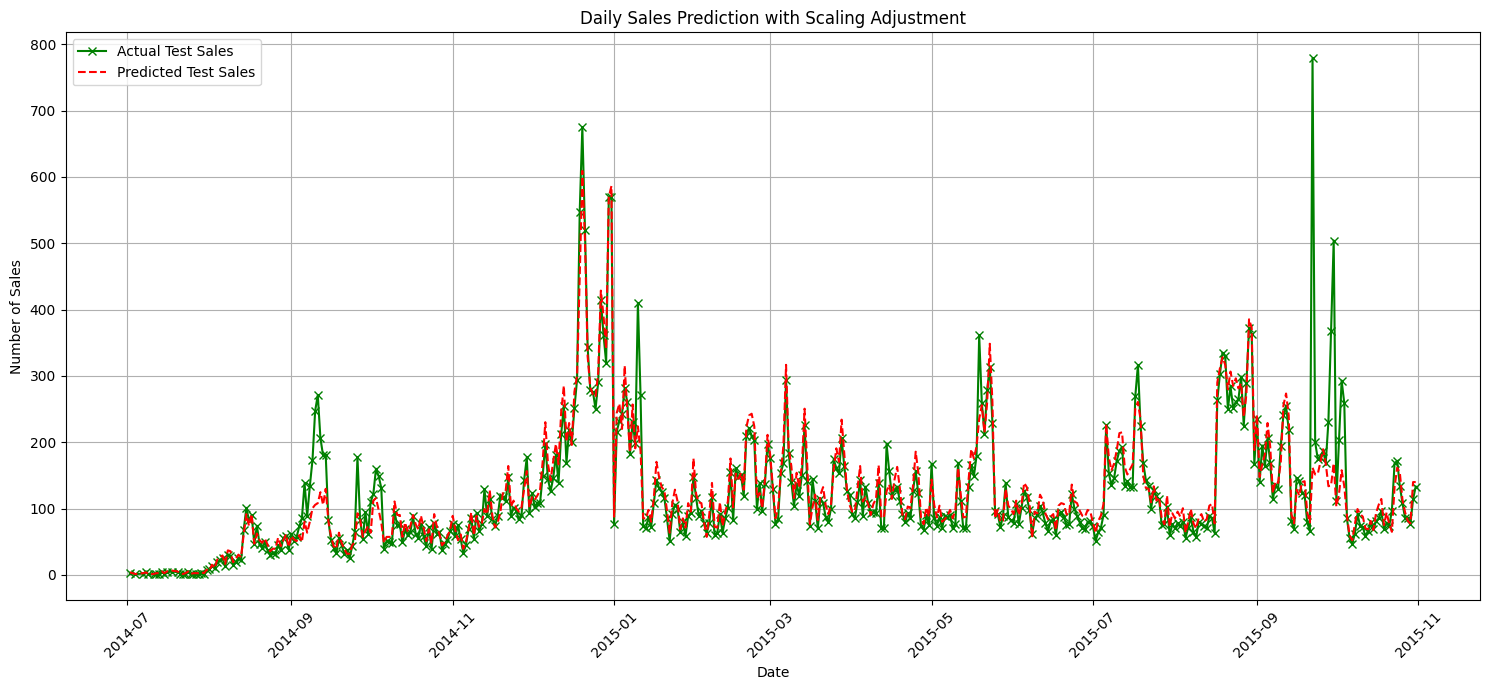

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

test_df = pd.DataFrame({
    'date': X_test['date'],
    'actual_sales': actual,
    'predicted_sales': predictions
})

daily_test = test_df.groupby('date').agg({
    'actual_sales': 'sum',
    'predicted_sales': 'sum'
}).reset_index()

plt.figure(figsize=(15, 7))
plt.plot(daily_test['date'], daily_test['actual_sales'], label='Actual Test Sales', color='green', marker='x')
plt.plot(daily_test['date'], daily_test['predicted_sales'], label='Predicted Test Sales', color='red', linestyle='--')
plt.title('Daily Sales Prediction with Scaling Adjustment')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
if hasattr(model, 'fc9'):  
    weights = model.fc9.weight.data.cpu().numpy()
    feature_names = X_train.drop(['date'], axis=1).columns
    for name, weight in zip(feature_names, weights[0]):
        print(f"Weight for {name}: {weight}")


Weight for shop_id: 0.19348174333572388
Weight for item_id: 0.015426508150994778
Weight for item_price: -0.059170886874198914
Weight for item_cnt_day: 0.3224934935569763
Weight for year: -0.1493644416332245
Weight for month: 0.32202252745628357
Weight for item_price_mean_week: -0.12204913794994354
Weight for item_cnt_day_mean_week: -0.03342887759208679
Weight for item_price_mean_month: 0.19268837571144104
Weight for item_cnt_day_mean_month: -0.00019111558503936976
Weight for item_category_id: 0.1298598200082779
Weight for day: 0.26226064562797546
Weight for day_of_week: -0.1746722012758255
Weight for is_weekend: -0.012313777580857277
Weight for day_of_year: -0.02417774312198162
